In [105]:
from dotenv import load_dotenv
from langgraph.graph import StateGraph
from zmq.decorators import context

load_dotenv()

True

In [106]:
# SQLite3 버전 문제 해결: Chroma는 SQLite3 3.35.0 이상이 필요하지만 시스템에는 낮은 버전이 설치되어 있음
# pysqlite3-binary를 사용하여 더 높은 버전의 SQLite3을 제공
import sys
import pysqlite3
# 기존 sqlite3 모듈을 pysqlite3으로 대체
sys.modules['sqlite3'] = pysqlite3
print(f"Using SQLite version: {pysqlite3.sqlite_version}")

Using SQLite version: 3.46.1


In [107]:
import chromadb
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

# ChromaDB 클라이언트를 생성합니다.
client = chromadb.PersistentClient(path='./brief')


embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

# 컬랙션이 이미 존재할 때는 Chroma 클래스 생성자 사용하여 객체 생성
vector_store = Chroma(
    client=client,
    embedding_function=embedding_function,
    collection_name = 'brief'
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

Failed to send telemetry event ClientStartEvent: module 'chromadb' has no attribute 'get_settings'
Failed to send telemetry event ClientCreateCollectionEvent: module 'chromadb' has no attribute 'get_settings'


In [108]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

In [109]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [110]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
from langchain_openai import ChatOpenAI

client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
llm = ChatOpenAI(model="gpt-4o")

In [111]:
def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | llm
    response = rag_chain.invoke({'context': context, 'question': query})
    return {'answer': response}

In [112]:
# Create a LANGSMITH_API_KEY in Settings > API Keys
from langsmith import Client
client = Client()
relevance_doc_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

In [113]:
from typing import Literal

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    relevance_doc_chain = relevance_doc_prompt | llm
    response = relevance_doc_chain.invoke({'question': query, 'documents': context})
    if response['Score'] == 1:
        return 'generate'

    return 'rewrite'

In [114]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['LLM -> 생성형AI', '돈 관련 단위 -> 달러']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고 우리의 사전을 참고해서 사용자의 질문을 변경해주세요
사전 : {dictionary}
질문 : {{query}}
                                              """)

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [115]:
from langgraph.graph import StateGraph

graph_builder = StateGraph(AgentState)

graph_builder.nodes.clear()

graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [116]:
from langgraph.graph import START, END

graph_builder.edges.clear()

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [117]:
graph = graph_builder.compile()

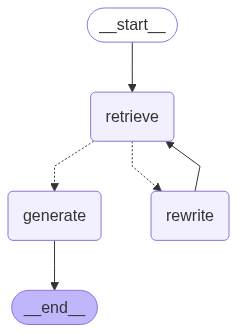

In [118]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [119]:
initial_state = {'query' : '구글의 LLM 관련 투자 규모는'}
graph.invoke(initial_state)

{'query': '구글의 LLM 관련 투자 규모는',
 'context': [Document(id='09964d55-41c0-4798-acc7-e9a7a47b59d6', metadata={'source': './documents/brief_2023년12월호_f.txt'}, page_content='아마존과 구글의 앤스프릭 투자에 앞서, 마이크로소프트는 차세대 AI 모델의 대표 주자인 오픈AI와 협력 확대\n\n마이크로소프트는 오픈AI에 앞서 투자한 30억 달러에 대해 2023년 1월 추가로 100억 달러를 투자하기로 하면서 오픈AI의 지분 49%를 확보했으며, 오픈AI는 마이크로소프트의 애저(Azure) 클라우드 플랫폼을 사용해 AI 모델을 훈련\n\n구글, 클라우드 경쟁력 강화를 위해 생성 AI 투자 확대\n\n구글은 수익성이 높은 클라우드 컴퓨팅 시장에서 아마존과 마이크로소프트를 따라잡고자 생성 AI를 통한 기업 고객의 클라우드 지출 확대를 위해 AI 투자 지속\n구글은 앤스프릭 외에도 동영상 제작 도구를 개발하는 런웨이(Runway)와 오픈소스 소프트웨어 기업 허깅페이스(Hugging Face)에도 투자\n구글은 첫 GPT의 기반 기술과 직접 경쟁할 수 있는 차세대 LLM ‘제미니(Gemini)’를 포함한 자체 시스템 개발에도 수십억 달러를 투자했으며, 2024년 제미니를 출시할 계획\n\n출처: The Wall Street Journal, Google Commits $2 Billion in Funding to AI Startup Anthropic, 2023.10.27. Bloomberg, AI Startup Anthropic to Use Google Chips in Expanded Partnership, 2023.11.09.\nIDC, 2027년 AI 소프트웨어 매출 2,500억 달러 돌파 전망\nKEY Contents\n\nIDC의 예측에 의하면 AI 소프트웨어 시장은 2027년 2,510억 달러로 성장하며, 생성 AI 플랫폼과 애플리케이션은 202